In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import SeasonalAD

import statsmodels.api as sm
import matplotlib.pyplot as plt

pd.options.mode.copy_on_write = True
warnings.filterwarnings("ignore")

In [63]:
# Let's see the dataframe of the demand
df = pd.read_csv('./sales_data/historical_demand.csv')
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [64]:
# Let's see the info and evalute the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1048575 non-null  object
 1   Warehouse         1048575 non-null  object
 2   Product_Category  1048575 non-null  object
 3   Date              1037337 non-null  object
 4   Order_Demand      1048575 non-null  object
dtypes: object(5)
memory usage: 40.0+ MB


In [65]:
# Let's change the date to datetime and Order_Demand to int
df['Date'] = pd.to_datetime(df['Date'])
df['Order_Demand'] = df['Order_Demand'].str.replace('(', '').str.replace(')', '').str.replace(',', '').astype(int)
# Let's set our date as index
df.set_index('Date', inplace=True)

/var/folders/pb/qp199g_d1w37vfktmm2c9hgh0000gn/T/ipykernel_9719/2834442064.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Order_Demand'] = df['Order_Demand'].str.replace('(', '').str.replace(')', '').str.replace(',', '').astype(int)


In [66]:
# Let's see how many rows are the null values
df.isnull().sum()

Product_Code        0
Warehouse           0
Product_Category    0
Order_Demand        0
dtype: int64

In [67]:
# Our null values represent 0.1% of the data, so we can drop them and not lose much information
df = df.dropna()

## Let's answer some questions first

1. Which are the top products by demand volume? Does this vary by warehouse?
2. How many unique products are there per category?
3. What's the demand distribution within each product category?
4. Are there any products with intermittent or sporadic demand?

In [68]:
# Which are the top products by demand volume? Does this vary by warehouse?
df.groupby('Warehouse')['Product_Code'].value_counts().groupby('Warehouse').head(1)

Warehouse  Product_Code
Whse_A     Product_1496     3339
Whse_C     Product_0349     1150
Whse_J     Product_1359    16936
Whse_S     Product_1341     1892
Name: Product_Code, dtype: int64

In [69]:
# We have a huge difference with the product_1359. Let's see how many products we have in each warehouse
df.groupby('Warehouse')['Product_Code'].nunique()

Warehouse
Whse_A     427
Whse_C     244
Whse_J    1625
Whse_S     553
Name: Product_Code, dtype: int64

In [70]:
# As expected, the warehouse_J is the one with more products comparing to the others. Let's check the product_1359 in each warehouse
df[df['Product_Code'] == 'Product_1359'].groupby('Warehouse')['Product_Code'].count()

Warehouse
Whse_J    16936
Name: Product_Code, dtype: int64

In [71]:
# That's means that not all the products are been delivered to the warehouses. Let's count which products are in all the warehouses
counts = df.groupby('Product_Code')['Warehouse'].nunique()

# Now let's filter those ones that are 4
products_in_all_warehouses = counts[counts == 4].index

# Let's storage the products available in the warehouse for later use
products_in_all_warehouses

Index(['Product_0125', 'Product_0200', 'Product_0206', 'Product_0226',
       'Product_0250', 'Product_0288', 'Product_0304', 'Product_0349',
       'Product_0412', 'Product_0453', 'Product_0458', 'Product_0463',
       'Product_0471', 'Product_0639', 'Product_0642', 'Product_0905',
       'Product_1264', 'Product_1387', 'Product_1432', 'Product_1521',
       'Product_1792', 'Product_1825', 'Product_1847', 'Product_1886',
       'Product_2138', 'Product_2166', 'Product_2167', 'Product_2169'],
      dtype='object', name='Product_Code')

In [72]:
# How many are they?
len(products_in_all_warehouses)

28

#### Let's continue with our next question:

In [73]:
# How many unique products are there per category?
df.groupby('Product_Category')['Product_Code'].nunique().sort_values(ascending=False)

Product_Category
Category_019    534
Category_001    278
Category_005    185
Category_021    143
Category_007    141
Category_006    112
Category_009    102
Category_030     99
Category_015     64
Category_023     62
Category_011     59
Category_028     57
Category_024     53
Category_032     49
Category_022     46
Category_026     41
Category_012     24
Category_020     23
Category_018     16
Category_013     13
Category_003     12
Category_017      8
Category_010      7
Category_008      7
Category_031      6
Category_016      4
Category_029      4
Category_033      4
Category_025      2
Category_027      2
Category_002      1
Category_014      1
Category_004      1
Name: Product_Code, dtype: int64

In [74]:
# Let's how many categories we have
df['Product_Category'].nunique()

33

#### Great, now that we have the category defined. Let's continue with the following questions:

In [75]:
# What's the demand distribution within each product category?
df.groupby('Product_Category')['Order_Demand'].describe()

,count,mean,std,min,25%,50%,75%,max
Product_Category,,,,,,,,
Category_001,97787.0,17.972461,53.289488,0.0,1.00,5.0,15.00,2075.0
Category_002,77.0,8.155844,10.509476,1.0,3.00,4.0,8.00,60.0
Category_003,4189.0,93.805204,195.575632,0.0,18.00,30.0,81.00,1860.0
Category_004,329.0,301.051672,298.082940,0.0,100.00,200.0,400.00,2400.0
Category_005,101671.0,1963.994846,7307.918090,0.0,200.00,500.0,1000.00,500000.0
Category_006,35577.0,11400.043005,31693.336846,0.0,1000.00,2500.0,10000.00,1000000.0
Category_007,82402.0,1561.752518,16170.958578,0.0,10.00,100.0,200.00,1144000.0
Category_008,1560.0,11.261538,21.947855,0.0,2.00,4.0,10.00,200.0
Category_009,19738.0,191.617236,493.408832,0.0,20.00,50.0,192.00,26759.0


We can observe that the demand for each category is different. This is the first step to understand what type of demand we have and start thinking in the forecast model that we can use. Let's go with the other questions.

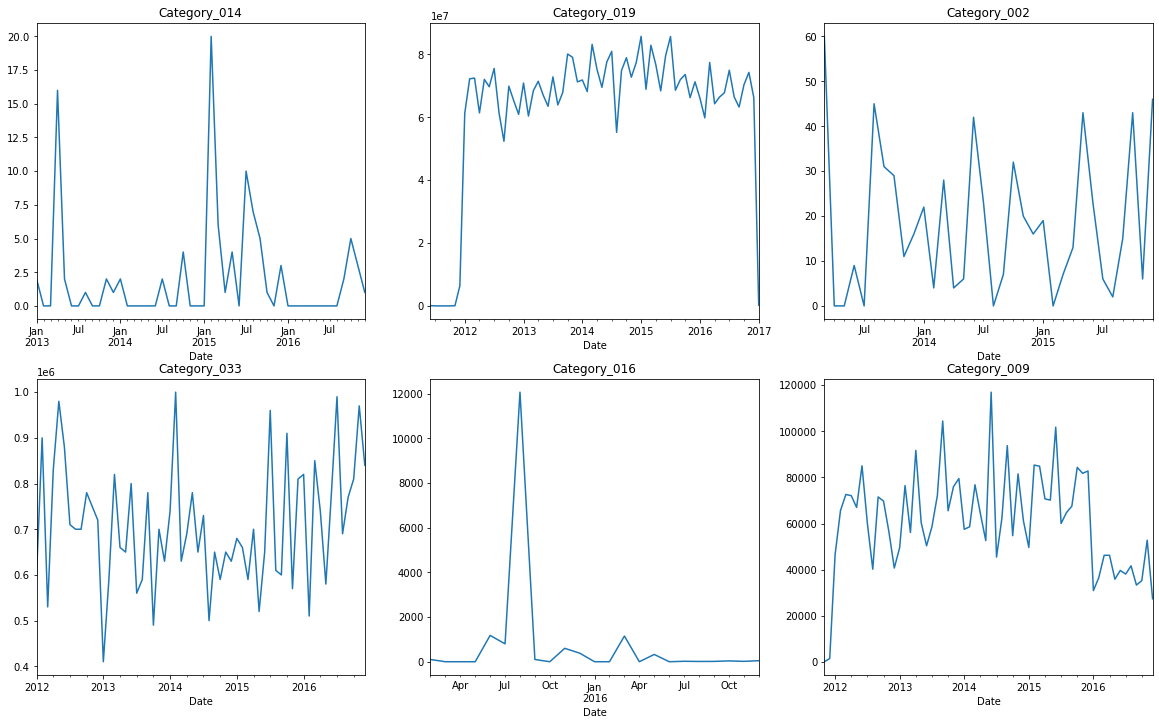

In [83]:
# Are there any products with intermittent or sporadic demand? After seen the distribuiton, let's see how is the demand over the time of some caterogies. Let's start with Category_014
categories = ['Category_014', 'Category_019', 'Category_002', 'Category_033', 'Category_016', 'Category_009']

# Let's see the demand over the time for each category in a box of 3,3
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
for i, category in enumerate(categories):
    ax = axes[i//3, i%3]
    df[df['Product_Category'] == category].resample('M')['Order_Demand'].sum().plot(ax=ax)
    ax.set_title(category)

Yes, we can observe in the charts that some products have a high demand, but others have a low demand. This is important to understand the demand distribution within each product category.

### Let's go to analyse our warehouses data
Warehouse Analysis:
1. How does demand vary across different warehouses?
2. Is there any geographical seasonality specific to certain warehouses?
3. What's the product mix in each warehouse?


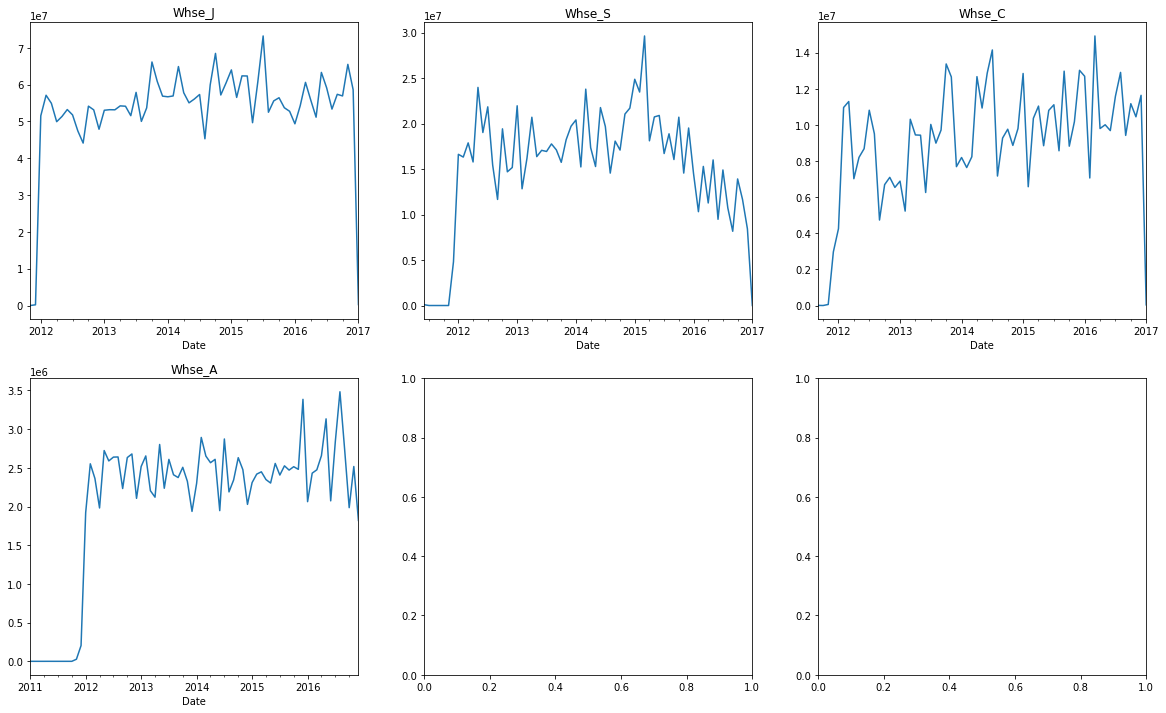

In [86]:
# How does demand vary across different warehouses?

# Let's see the demand over the time for each warehouse in a box of 3,3
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
for i, warehouse in enumerate(df['Warehouse'].unique()):
    ax = axes[i//3, i%3]
    df[df['Warehouse'] == warehouse].resample('M')['Order_Demand'].sum().plot(ax=ax)
    ax.set_title(warehouse)

We have a massive drop in the demand in the first three warehouses in the last period. Let's have a look on this period to understand what happened.

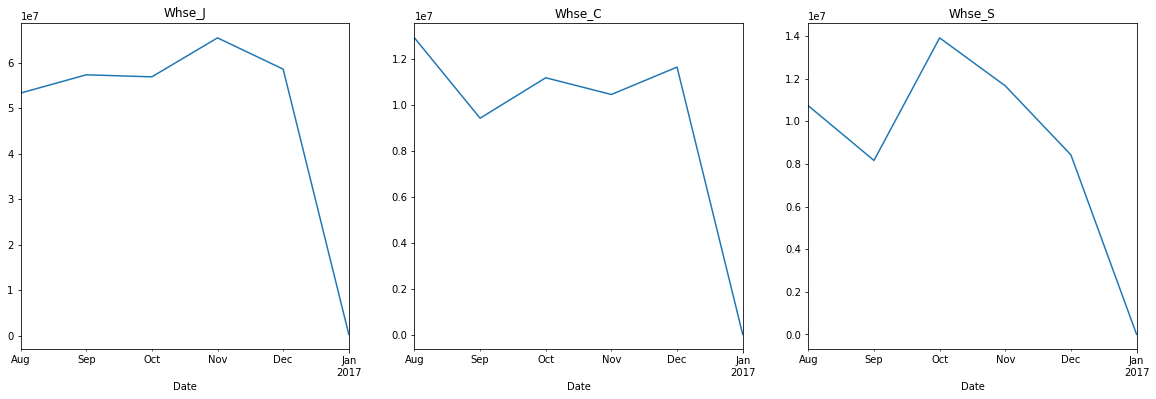

In [92]:
# Let's see the demand in the last 6 months of the warehouse_J, warehouse_S and warehouse_C
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for i, warehouse in enumerate(['Whse_J', 'Whse_C', 'Whse_S']):
    ax = axes[i]
    df[df['Warehouse'] == warehouse].resample('M')['Order_Demand'].sum().tail(6).plot(ax=ax)
    ax.set_title(warehouse)

In [95]:
# All of them are the same, let's have a look on the table the last 6 months
df.resample('M')['Order_Demand'].sum().tail(14)

Date
2015-12-31    88676245
2016-01-31    78627619
2016-02-29    74065041
2016-03-31    93303910
2016-04-30    79503364
2016-05-31    80299593
2016-06-30    84553011
2016-07-31    88439936
2016-08-31    80471772
2016-09-30    77698896
2016-10-31    84000757
2016-11-30    90128568
2016-12-31    80497932
2017-01-31      294967
Name: Order_Demand, dtype: int64

Comparing to previous years, the month of January is expected to have a lower demand but not as this. For our practice we will remove this month from the analysis.

In [96]:
# Let's remove the last month of the dataset
df = df.loc[:'2016-12-31']

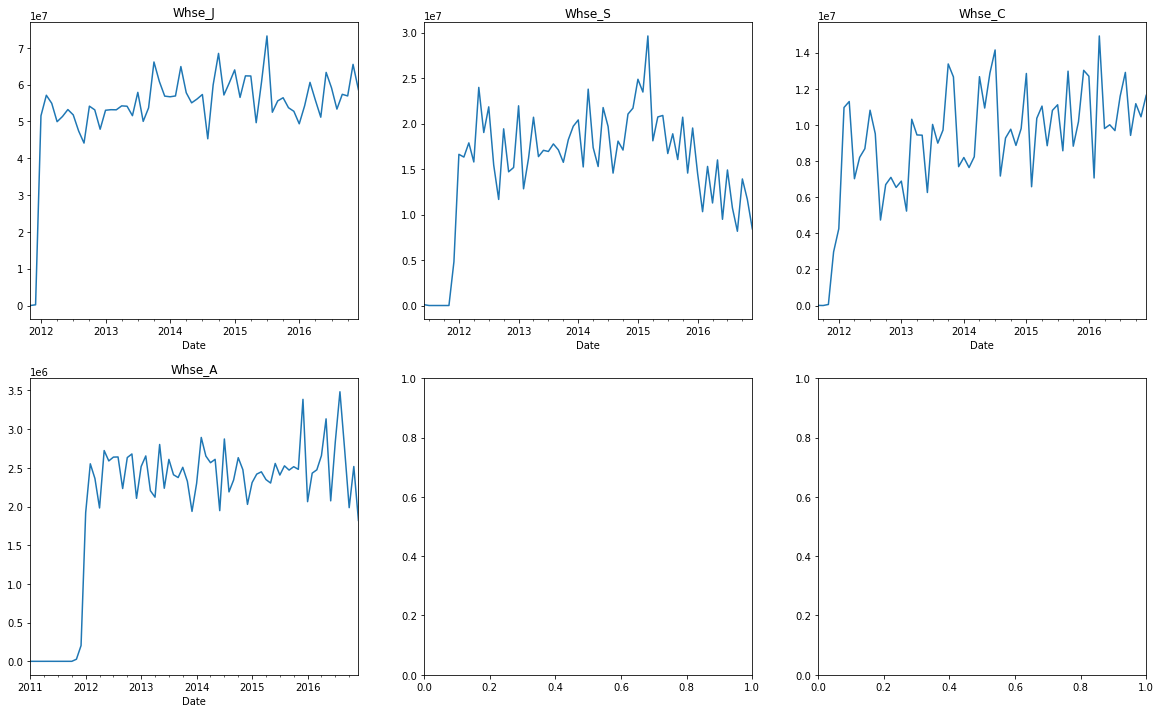

In [98]:
# Let's have a look again the charts

# Let's see the demand over the time for each warehouse in a box of 3,3
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
for i, warehouse in enumerate(df['Warehouse'].unique()):
    ax = axes[i//3, i%3]
    df[df['Warehouse'] == warehouse].resample('M')['Order_Demand'].sum().plot(ax=ax)
    ax.set_title(warehouse)

Now we can see tha some warehouses have different trends. A and J have a similar trend that is more stable. S is showing a decreasing trend and C is showing an increasing trend. This is important to understand the demand in each warehouse.

#### Let's continue with the following questions:

In [99]:
# What's the product mix in each warehouse?
# Let's see the top 5 products in each warehouse
df.groupby('Warehouse')['Product_Code'].value_counts().groupby('Warehouse').head(5) 

Warehouse  Product_Code
Whse_A     Product_1496     3333
           Product_1470     3096
           Product_0200     2472
           Product_1410     2145
           Product_1424     2126
Whse_C     Product_0349     1150
           Product_2167     1027
           Product_0191      940
           Product_0202      855
           Product_0495      787
Whse_J     Product_1359    16935
           Product_1295    10575
           Product_1378     9770
           Product_1286     8888
           Product_1382     8619
Whse_S     Product_1341     1892
           Product_0033     1149
           Product_1431      939
           Product_1342      895
           Product_1263      889
Name: Product_Code, dtype: int64

In [116]:
# Let's evaluate Whse_A and see how is the distribution of the category in percentage for the warehouse
df[df['Warehouse'] == 'Whse_A']['Product_Category'].value_counts(normalize=True)*100

Category_019    43.950933
Category_007    10.579193
Category_021     9.545020
Category_028     7.839197
Category_009     5.255171
Category_024     4.702956
Category_015     3.996178
Category_006     2.754047
Category_026     2.350073
Category_018     1.849848
Category_003     1.363675
Category_005     1.067193
Category_031     0.923870
Category_013     0.785465
Category_022     0.687809
Category_011     0.561348
Category_010     0.517789
Category_029     0.471420
Category_023     0.238871
Category_017     0.172128
Category_012     0.149646
Category_008     0.118031
Category_001     0.089225
Category_027     0.018267
Category_016     0.012646
Name: Product_Category, dtype: float64

In [42]:
# what category is product_1359?
df[df['Product_Code'] == 'Product_1359']['Product_Category'].unique()

array(['Category_019'], dtype=object)